In [1]:
import sys
import os
import numpy as np
import csv
import pandas as pd
from scipy import signal
from matplotlib import pyplot as plt

In [2]:
# User Inputs
data = 'Engine RPM'
sata = 'Engine coolant temperature'
overHeat = 1

# Defaults
tsorder  = 1
tscutoff = [0.001,.007]
sataMean = 212.5
sataStd = 20
in_csvFullFile = '/home/mapr/projects/demo_jam/data/demo_jam_dataset/dataset1/2HMDJJFB2JJ000017.csv'
in_csvPath, in_csv = os.path.split(in_csvFullFile)
in_csvRoot = in_csv.split('.')[0]

# Subroutine: Zero Mean Unit Variance

In [3]:
def tszmuv(in_df):
    in_dfmean = in_df.mean()
    in_dfstd = in_df.std()
    out_df = (in_df.values-in_dfmean)/in_dfstd
    return out_df

# Subroutine: Convolve Timeseries

In [4]:
def tsfilter(in_array, order, cutoff):
    b, a = signal.butter(order, cutoff, btype='band')
    #y = signal.filtfilt(b, a, in_array, padlen=150)
    y = signal.lfilter(b, a, in_array)
    return b, a, y

# Subroutine: Add Mean and Variance

In [5]:
def tsmv(in_df, in_dfmean, in_dfstd):
    out_df= in_df*in_dfstd+in_dfmean
    return out_df

# Read CSV file

In [6]:
df1 = pd.read_csv(in_csvFullFile)

In [7]:
df_data = tszmuv(df1[data])
df_speed = tszmuv(df1['Vehicle Speed'])
df2 = pd.concat([pd.DataFrame(df_data), pd.DataFrame(df_speed)], axis=1)
corr = df2.corr().iloc[0,1] 

In [8]:
b, a, y3 = tsfilter(df_data, tsorder, tscutoff)

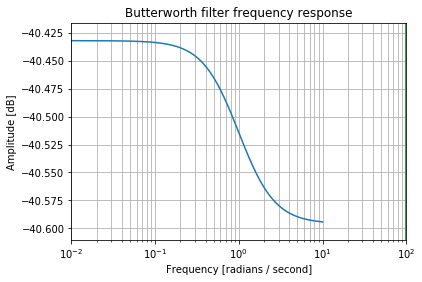

In [9]:
w, h = signal.freqs(b, a)
plt.semilogx(w, 20 * np.log10(abs(h)))
plt.title('Butterworth filter frequency response')
plt.xlabel('Frequency [radians / second]')
plt.ylabel('Amplitude [dB]')
plt.margins(0, 0.1)
plt.grid(which='both', axis='both')
plt.axvline(100, color='green') # cutoff frequency
plt.show()

In [1]:
%matplotlib inline
plt.figure()
total_rows=len(df1.index)
x = np.transpose(range(0, total_rows, 1))
y1 = df_data
y2 = df_speed
datasata = pd.concat([pd.DataFrame(y1), pd.DataFrame(y3)], axis=1)

plt.plot(x,y1, 'g-')
plt.plot(x,y2, 'b-')
plt.plot(x,y3, 'r-')
corr = datasata.corr().iloc[0,1]
print(corr)

NameError: name 'plt' is not defined

In [11]:
df1[sata] = pd.DataFrame({'sata' : tsmv(y3, sataMean, sataStd)})

nan


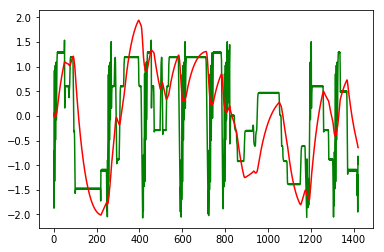

In [18]:
%matplotlib inline
plt.figure()
total_rows=len(df1.index)
x = np.transpose(range(0, total_rows, 1))
y1 = df_data
y2 = df_speed
datasata = pd.concat([pd.DataFrame(y1), pd.DataFrame(y3)], axis=1)

plt.plot(x,y1, 'g-')
#plt.plot(x,y2, 'b-')
plt.plot(x,tszmuv(df1[sata]), 'r-')
corr = datasata.corr().iloc[0,1]
print(corr)

In [13]:
df2=df1.drop(df1.columns[0], axis=1)
df2.head()

,VIN,Make,Year,t,Timestamp,Latitude,Longitude,Vehicle Speed,Instant Fuel Economy,Total Fuel Economy,Fuel rate,Engine coolant temperature,Engine RPM,Altitude,Absolute throttle position,Time since engine start,Ambient air temperature,odometer,target
0,2HMDJJFB2JJ000017,Acme_Motors,2018,1.550000e+09,2019-01-28 7:49:25,42.368703,-92.893446,8.219294,1247.838037,459.269260,0.03889,212.366395,1376.527158,185.823467,1.658883,274.283034,23,23128.0,0
1,2HMDJJFB2JJ000017,Acme_Motors,2018,1.550000e+09,2019-01-28 7:49:26,42.368745,-92.893446,5.984629,980.508184,537.952370,0.03889,211.885592,1059.169117,208.330453,0.465654,256.395167,27,23128.0,0
2,2HMDJJFB2JJ000017,Acme_Motors,2018,1.550000e+09,2019-01-28 7:49:27,42.368775,-92.893446,4.767392,579.703758,441.285350,0.03889,211.542015,1564.806634,183.267129,3.285536,151.211448,29,23128.0,0
3,2HMDJJFB2JJ000017,Acme_Motors,2018,1.550000e+09,2019-01-28 7:49:28,42.368805,-92.893446,5.690339,504.604739,507.105611,0.03889,211.726815,1825.620989,169.813630,6.787972,274.387898,31,23128.0,0
4,2HMDJJFB2JJ000017,Acme_Motors,2018,1.550000e+09,2019-01-28 7:49:29,42.368842,-92.893446,7.064131,48.137011,428.017971,0.03889,211.665768,1208.747739,138.282742,9.305387,152.126873,0,23128.0,0


# Target Generation

In [14]:
df3=df2
total_rows=len(df3.index)

In [15]:
if int(overHeat) > 0:
    failMax = df3[sata].iloc[0:int(total_rows/2)].max()
    failMaxIndex = df3[sata].loc[df3[sata] == df3[sata].iloc[0:int(total_rows/2)].max()].index[0]      
    targetOn = list(range(failMaxIndex, len(df3)-1))
    numerator = np.asarray(targetOn)-targetOn[0]+1
    for ii in targetOn:
        # triggering value+ramp to 265+noise
        shift = -1*targetOn[0]
        df3[sata].iloc[ii] = failMax+((numerator[ii+shift]/numerator[-1])*(265-failMax))+np.random.randn()
#        if ii-3 < 0:
#            df3[sata].iloc[ii] = (failMax+((numerator[ii+shift]/numerator[-1])*(265-failMax))+np.random.randn())
#        else:
#            smooth = (0.08*df3[sata].iloc[ii-3])+(0.17*df3[sata].iloc[ii-2])+(0.25*df3[sata].iloc[ii-1])
#            df3[sata].iloc[ii] = smooth+0.5*(failMax+((numerator[ii+shift]/numerator[-1])*(265-failMax))+np.random.randn())
    df3['target'].iloc[total_rows-1] = 1

/home/mapr/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


0.13270229587169582


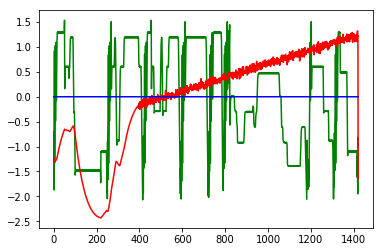

In [16]:
%matplotlib inline
plt.figure()
x = np.transpose(range(0, total_rows, 1))
y1 = df_data
y2 = tszmuv(df3[sata])
y3 = df1['target']
testCorr = pd.concat([pd.DataFrame(y1), pd.DataFrame(y2)], axis=1)

plt.plot(x,y1, 'g-') # RPM
plt.plot(x,y2, 'r-') # Temperature
plt.plot(x,y3, 'b-') # Target
corr = testCorr.corr().iloc[0,1]
print(corr)

In [17]:
# Save CSV File
df3.to_csv(in_csvRoot+'_ee.csv', header=False)